In [1]:
import pandas as pd
import numpy as np
import math
from math import cos, sin, pi
import matplotlib.pyplot as plt

### Shape function 


In [16]:
df = pd.read_csv('../../datasets/epac-atl.csv')

In [17]:
df.to_csv('../../datasets/epac-atl.csv')

In [18]:
def dist_(x1,y1,x2,y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [19]:
def shift_reset (df_new, radius_col):
    df_new['long_1'] = df_new.groupby(['name'])['long'].shift(-1)
    df_new['lat_1'] = df_new.groupby(['name'])['lat'].shift(-1)
    df_new[radius_col+'_1'] = df_new.groupby(['name'])[radius_col].shift(-1)
    df_new_new =df_new.reset_index()
    return df_new_new

In [20]:
def shift_only(df_new, radius_col):
    df_new['long_1'] = df_new.groupby(['name'])['long'].shift(-1)
    df_new['lat_1'] = df_new.groupby(['name'])['lat'].shift(-1)
    df_new[radius_col+'_1'] = df_new.groupby(['name'])[radius_col].shift(-1)
 
    return df_new

In [21]:
def copy_long_lat(df_new, radius_col ):
    initial_lat=df_new["lat"].iloc[-1]
    initial_long=df_new["long"].iloc[-1]
    initial_r=df_new[radius_col+'_dg'].iloc[-1]
    for i in range(len(df_new)):
        lat1= df_new.loc[i,'lat'] 
        long1= df_new.loc[i,'long']
        r1= df_new.loc[i,radius_col+'_dg']
     
        list_ = []
        for j in range(i+1,len(df_new)):
            lat2= df_new.loc[j,'lat'] 
            long2= df_new.loc[j,'long']
        #r2= df_new.loc[j,radius_col+'_dg']
            if dist_(-long2,lat2,-long1,lat1)<r1:
                df_new.loc[j,'lat'] = df_new.loc[i,'lat']
                df_new.loc[j,'long'] = df_new.loc[i,'long']
                df_new.loc[j,radius_col+'_dg'] = df_new.loc[i,radius_col+'_dg']
    return df_new

In [22]:
def shift_and_drop (df_new, radius_col):
    df_new['long_1'] = df_new.groupby(['name'])['long'].shift(-1)
    df_new['lat_1'] = df_new.groupby(['name'])['lat'].shift(-1)
    df_new[radius_col+'_1'] = df_new.groupby(['name'])[radius_col].shift(-1)
    df_new = df_new.drop(['index'], axis=1)
    df_new =df_new.reset_index()
    df_new = df_new.drop(['level_0'], axis=1)
    return df_new

In [23]:
def shift_ (df_new, radius_col):
    df_new['long_1'] = df_new.groupby(['name'])['long'].shift(-1)
    df_new['lat_1'] = df_new.groupby(['name'])['lat'].shift(-1)
    df_new[radius_col+'_1'] = df_new.groupby(['name'])[radius_col].shift(-1)
    df_new_new =df_new.reset_index()
    return df_new_new
    

In [24]:
def shape_func(df, name, year, radius_col):
    def big_wind_plt(row):
        """
        returns the 4 outer tangential points of 2 circles (x1, y1) and (x2, y2) with radii r1 and r2
        reference: https://en.wikipedia.org/wiki/Tangent_lines_to_circles
        """
        x1 = row['lat']
        x2 = row['lat_1']
        y1 = row['long']
        y2 = row['long_1']
        r1 =row[radius_col]
        r2 =row[radius_col+'_1']

        r1 /= 60
        r2 /= 60
        dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if dist == 0 :
            return [0,0,0,0], [0,0,0,0]
        gamma = -np.arctan((y2-y1)/(x2-x1))
        beta = np.arcsin((r2-r1)/dist)
        alpha = gamma - beta

          # points (x3, y3) and (x4, y4)
        x3 = x1 + (r1 * cos( pi / 2 - alpha))
        y3 =  y1 + (r1 * sin( pi / 2 - alpha))
        x4 =  x2 + (r2 * cos( pi / 2 - alpha))
        y4 =  y2 + (r2 * sin( pi / 2 - alpha))

          # points (x5, y5) and (x6, y6)
        x5 = x1 - (r1 * cos( pi / 2 - alpha))
        y5 =  y1 - (r1 * sin( pi / 2 - alpha))
        x6 =  x2 - (r2 * cos( pi / 2 - alpha))
        y6 =  y2 - (r2 * sin( pi / 2 - alpha))

        return [( y3, x3), (y4, x4), (y6,  x6),  ( y5, x5)]





    df_new=df[df['name']== name][df['year']== year]
    df_new[radius_col+'_dg']=df_new[radius_col]/60
    df_new = df_new.reset_index()
    
    df_new = shift_reset (df_new, radius_col)
 
    for index, row  in  df_new.iterrows():
        if row['lat'] ==row['lat_1']:
            df_new.drop(index+1, inplace=True)
    df_new = df_new.drop(['index'], axis=1)
    df_new =df_new.reset_index()



    copy_long_lat(df_new, radius_col )
        
    df_new=shift_and_drop(df_new, radius_col)

    df_new =df_new.reset_index()
    df_new = df_new.drop(['level_0'], axis=1)
    for index, row  in  df_new.iterrows():
        if row['lat'] ==row['lat_1']:
            df_new.drop(index+1, inplace=True)
      
    df_new =df_new.reset_index()      

    shift_only (df_new, radius_col)
  #df_new['shape'] = df_new.apply(big_wind_34, axis=1)
    df_new['shape_plt'+radius_col] = df_new.apply(big_wind_plt, axis=1)
    poly = np.array(df_new['shape_plt'+radius_col] )
    long =  np.array(df_new['long'])
    lat =  np.array(df_new['lat'])
    r =  np.array(df_new[radius_col])


  
    
    return poly , long, lat, r

In [25]:
poly_arr = np.array(shape_func(df, 'ADOLPH', 2001, 'max_34'))

/Users/anurkayeva/anaconda3/envs/omdena/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/anurkayeva/anaconda3/envs/omdena/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arcsin
  app.launch_new_instance()


In [26]:
shape_func(df, 'ADOLPH', 2001, 'max_34')


/Users/anurkayeva/anaconda3/envs/omdena/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/anurkayeva/anaconda3/envs/omdena/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arcsin
  app.launch_new_instance()


(array([list([(-101.1, 13.6), (-101.2, 13.7), (-101.2, 13.7), (-101.1, 13.6)]),
        list([(-101.2, 13.7), (-101.2, 13.8), (-101.2, 13.8), (-101.2, 13.7)]),
        list([(-101.2, 13.8), (-100.9, 13.7), (-100.9, 13.7), (-101.2, 13.8)]),
        list([(nan, nan), (nan, nan), (nan, nan), (nan, nan)]),
        list([(-99.40249232021914, 14.854294491178127), (-101.00249232021913, 16.25429449117813), (-103.19750767978086, 13.745705508821873), (-101.59750767978086, 12.345705508821872)]),
        list([(-101.40827794272215, 16.516343751678058), (-103.3353474284027, 17.395429689597574), (-105.0646525715973, 13.604570310402426), (-102.79172205727784, 13.483656248321942)]),
        list([(-104.1381599617348, 17.58241532539624), (-106.95052796938784, 17.665932260316993), (-107.04947203061216, 14.334067739683007), (-104.2618400382652, 13.417584674603757)]),
        list([(-106.72600168782441, 17.643989873053574), (-109.12600168782441, 18.043989873053572), (-109.6739983121756, 14.756010126946425

/Users/anurkayeva/anaconda3/envs/omdena/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/anurkayeva/anaconda3/envs/omdena/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in arcsin
  app.launch_new_instance()


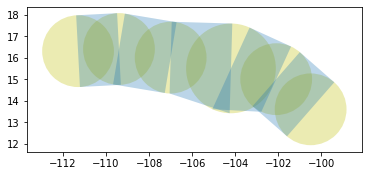

In [27]:
 
c1 = shape_func(df, 'ADOLPH', 2001, 'max_34')[1]
c2 = shape_func(df, 'ADOLPH', 2001, 'max_34')[2]
p__ = shape_func(df, 'ADOLPH', 2001, 'max_34')[0]
rmw = shape_func(df, 'ADOLPH', 2001, 'max_34')[3]
import matplotlib.pyplot as plt

plt.axes()




for i,j,rr in zip(c1,c2,rmw):
   plt.gca().add_patch( plt.Circle(( np.array(i),  np.array(j)),  np.array(rr)/60, fc='y',  alpha=0.3))
    
   

for i in p__:
    plt.gca().add_patch(plt.Polygon(np.array(i), alpha=0.3) )


plt.axis('scaled')
plt.show()